<a href="https://colab.research.google.com/github/Vinicius-S-Grilo/Portfolio/blob/main/MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - Vinicius Simas Grilo**

Inicio o trabalho importado os dados do meu google drive para o collab.

In [1]:
#Baixando os dados do google Drive
import gdown

file_ids = ["11E2eFUgaNlXe-gWkDUZng-rftGXMnr4N",
            "1OwX71oOh_YH8ELpyw4Ip7JsIJYCO13fs",
            "1VnRfgI_v2777oqMZUmi-yDiOJrePp23g",
            "1gf_5tJ-pZfJpVqBmreK5R_hKWT2m8BCd",
            "1ghYzM3SQCnyy2HBhplMR0HsOFO-FePS1",
            "1l8ksAxJOl2NaFSbn2BqcSJj4mjMN4is1",
            "1oYSIIyTJI3ANEXtszvx9n2IJbcpqDUKy",
            "1YJbwftGveX-aW14NKOqPwxXI2Vk6xgnT",
            "1UlQ0q69ARLB-WBzo9x4VPGreCyvJDkaY",
            "1rKt9FDTlb5ozPl43qfQ5SBWmQQlN4BMd",
            "1bnZXRMZuLrs_Xjw80Xck3ru4Mxed4-E5",
            "1H9-AgsqYphGhf3wCwg-wrD5_f_finUyA",
            "1jgGdhvP2KPhGgB54mZeKi1QatCT4-cJA",
            "1FsLYvOQ1fL7odtYf38JIYdiudnnVzNaH",
            "1COrZ86oPWahYorwwdj8vRl2-IoVmUHko"]

for id in file_ids:
  url = f"https://drive.google.com/uc?id={id}"
  gdown.download(url)

Downloading...
From: https://drive.google.com/uc?id=11E2eFUgaNlXe-gWkDUZng-rftGXMnr4N
To: /content/data.csv
100%|██████████| 533k/533k [00:00<00:00, 81.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OwX71oOh_YH8ELpyw4Ip7JsIJYCO13fs
To: /content/train_loss.csv
100%|██████████| 1.22k/1.22k [00:00<00:00, 2.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VnRfgI_v2777oqMZUmi-yDiOJrePp23g
To: /content/real_pred.csv
100%|██████████| 131k/131k [00:00<00:00, 84.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gf_5tJ-pZfJpVqBmreK5R_hKWT2m8BCd
To: /content/MVP.ipynb
100%|██████████| 138k/138k [00:00<00:00, 65.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ghYzM3SQCnyy2HBhplMR0HsOFO-FePS1
To: /content/best_model.hdf5
100%|██████████| 663M/663M [00:09<00:00, 69.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l8ksAxJOl2NaFSbn2BqcSJj4mjMN4is1
To: /content/train_accuracy.csv
100%|██████████| 1.19k/1.19k [00:00<00:00, 2.32MB/s]
Downloading..

## **A - Machine Learning**

**Definição do problema**

O dataset escolhido aborda um problema de classificação. Trata-se de uma instituição de ensino superior que deseja avaliar se um aluno irá concluir ou desistir do curso baseado em uma série de atributos como curso, performace academica, fatores socio-econômicos entre outros.

mais informações a respeito do dataset pode ser encontrada em https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

Há três categorias possíveis: *dropout*, *enrolled* e *graduate*

O dataset já foi previamente preprocessado para remoção de missing values e outliers.

In [2]:
#importando as bibliotecas a serem utilizadas
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
import sklearn.metrics as skm
from google.colab import data_table
data_table.enable_dataframe_formatter()


**Preparação dos dados**

Como os dados já vieram pre processados, não há necessidade de utilizar técnicas de pre processamento para tratamento de missing values ou remoção de outliers.

Nesta etapa, será feito o carregamento do dataset, separação entre treino/teste, parametrização pra validação cruzada, criação e comparação dos modelos.

In [3]:
#Carregando o dataset
dataset = pd.read_csv(r"/content/data.csv", sep=';')

In [4]:
#Tratando os dados para treinamento do modelo
np.random.seed(10)

#separação dos atributos e da categoria
X = np.array(dataset.iloc[:,:-1].copy())
y = np.array(dataset.iloc[:,-1].copy())

#separação teste/treino
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

#Parâmetros para validação cruzada
n_part = 10
kfold = KFold(n_splits=n_part,shuffle=True, random_state=10)

#Criação e preparação dos modelos e seus resultados
models = []
results = []
names = []

models.append(("KNN",KNeighborsClassifier()))
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(("CART",DecisionTreeClassifier()))
models.append(("NB",GaussianNB()))
models.append(("SVC",SVC()))

for name,model in models:
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)


KNN: 0.5936788783790271 (0.027958817701309913)
LR: 0.6953793953361822 (0.025023645819575304)
CART: 0.6801323602375122 (0.01516551542951282)
NB: 0.6869056193082697 (0.029678089117343605)
SVC: 0.5035194699188554 (0.02250900968881935)


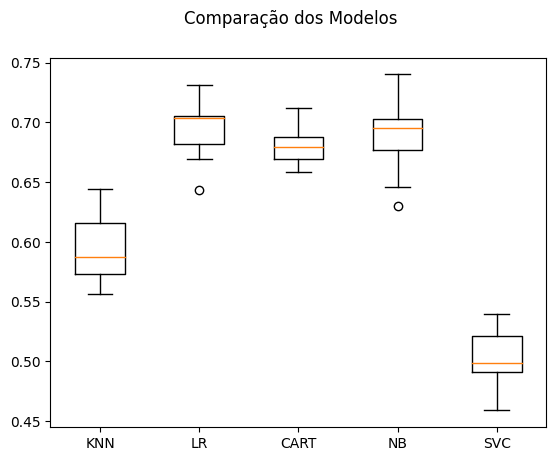

In [5]:
#Boxplot para comparar a precisão dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [6]:
#Averiguando métricas dos modelos com o dado teste
best_models_list = ["NB","CART","LR"]

metrics_comparison ={}


for i in models:
  if i[0] in best_models_list:
    model = i[1]
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    ind_metrics = {}
    a = accuracy_score(y_test,predictions)
    r = recall_score(y_test,predictions,average='weighted')
    p = precision_score(y_test,predictions,average='weighted')
    f = f1_score(y_test,predictions,average='weighted')
    ind_metrics['accuracy'] = a
    ind_metrics['recall'] = r
    ind_metrics['precision'] = p
    ind_metrics['f1_score'] = f
    metrics_comparison[i[0]]= ind_metrics
    print(f"Acurácia de {i[0]}: {a:.2%} ")
    print(f"Revocação de {i[0]}: {r:.2%} ")
    print(f"Precisão de {i[0]}: {p:.2%} ")
    print(f"F1 score de {i[0]}: {f:.2%} \n")



Acurácia de LR: 66.89% 
Revocação de LR: 66.89% 
Precisão de LR: 63.54% 
F1 score de LR: 62.23% 

Acurácia de CART: 68.14% 
Revocação de CART: 68.14% 
Precisão de CART: 67.65% 
F1 score de CART: 67.87% 

Acurácia de NB: 64.29% 
Revocação de NB: 64.29% 
Precisão de NB: 61.19% 
F1 score de NB: 62.26% 



Com base no plot acima, é possível perceber que o modelo com maior precisão é o de Regressão Logística (LR), seguido do Naive Bayes e da Árvore de Decisão. Como não há diferença estatística significativa entre os três modelos, vou seguir com eles para testar uma abordagem de feature selection e avaliar se a precisão dos modelos melhora.

In [7]:
#Testando feature selection pra otimizar modelo
#números de features a serem escolhidos
n = 15

print("Atributos Originais:\n", dataset.columns[0:36])
print("\n\n##Iniciando os testes com feature selection##\n\n")

#teste ANOVA de Seleção Univariada
best_var = SelectKBest(score_func=f_classif, k=n)

fit = best_var.fit(X,y)

features=fit.transform(X)

#Print dos resultados
print("Resultados do ANOVA - seleção univariada\n")
print(f"Atributos originais: {X.shape[1]}")
print(f"Atributos reduzidos: {features.shape[1]}")

print("Scores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset.columns[0:36]))

red_features_f = best_var.get_feature_names_out(input_features=dataset.columns[0:36])


# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=n)
fit = rfe.fit(X, y)

# Print dos resultados

print("\nResultados da Eliminação recursiva de atributos\n")


# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=dataset.columns[0:36]))
red_features_RFE = fit.get_feature_names_out(input_features=dataset.columns[0:36])

# Importância de Atributos com ExtraTrees
# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)


# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print("\nResultados da Importância de atributos com ExtraTrees\n")
print(modelo.feature_importances_)
ipt=modelo.feature_importances_
red_features_ExT = dataset.columns[0:36][ipt.argsort()[-n:]]
print(f"\nAtributos selecionados {red_features_ExT}\n")









Atributos Originais:
 Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
      

In [8]:
#Mostrando os top 15 atributos selcionados de acordo com as técnicas de feature selection

print(f"ANOVA - {red_features_f}\n")
print(f"RFE - {red_features_RFE}\n")
print(f"ExtraTrees - {red_features_ExT}")

ANOVA - ['Application mode' 'Admission grade' 'Debtor' 'Tuition fees up to date'
 'Gender' 'Scholarship holder' 'Age at enrollment'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'Curricular units 1st sem (grade)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'Curricular units 2nd sem (grade)']

RFE - ['Marital status' 'Displaced' 'Debtor' 'Tuition fees up to date' 'Gender'
 'Scholarship holder' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (approved)'
 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)'
 'Curricular units 2nd sem (without evaluations)']

ExtraTrees - Index(['Mother's occupation', 'Father's occupation', 'Applicatio

ANOVA training
LR-ANOVA: 0.7651886173396714 (0.014581238931198266)
RFE training
LR-RFE: 0.7674437028856773 (0.01766379139362151)
ExT training
LR-ExT: 0.7015972855748147 (0.025887845917512583)
ANOVA training
CART-ANOVA: 0.6747707303020117 (0.022876279745073468)
RFE training
CART-RFE: 0.7069645172132328 (0.029204952134647258)
ExT training
CART-ExT: 0.6789984155183176 (0.02623187833464461)
ANOVA training
NB-ANOVA: 0.7216641859125174 (0.021644211414913423)
RFE training
NB-RFE: 0.6897384804980715 (0.02215459519516164)
ExT training
NB-ExT: 0.7052808053648308 (0.019001207582004985)


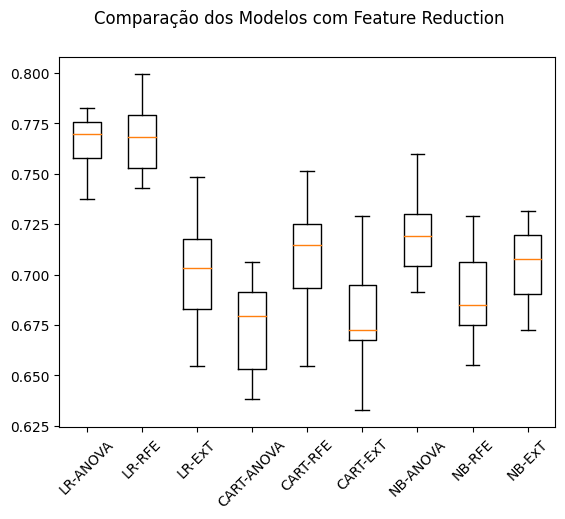

In [9]:
#Retreinando o modelo com inputs reduzidos de acordo com cada técnica

X_anova = np.array(dataset.loc[:,red_features_f].copy())
X_rfe = np.array(dataset.loc[:,red_features_RFE].copy())
X_ExT = np.array(dataset.loc[:,red_features_ExT].copy())

feat_red_tecs = [("ANOVA",X_anova),
                ("RFE", X_rfe),
                ("ExT",X_ExT)]

new_results = []
names = []

for name,model in models:
  for i in feat_red_tecs:
    if name in best_models_list:
      print(f"{i[0]} training")
      #new splits
      X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
      cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
      new_results.append(cv_results)
      names.append(name+"-"+i[0])

      msg = f"{name}-{i[0]}: {cv_results.mean()} ({cv_results.std()})"
      print(msg)
fig = plt.figure()
fig.suptitle(f'Comparação dos Modelos com Feature Reduction')
ax = fig.add_subplot(111)
plt.boxplot(new_results)
ax.set_xticklabels(names, rotation = 45)
plt.show()


In [10]:
#Testando a precisão dos modelos retreinados
predict_results = {}

for name,model in models:
  for i in feat_red_tecs:
    if name in best_models_list:
      model = model
      X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
      model.fit(X_train,y_train)
      predictions = model.predict(X_test)
      ind_metrics = {}
      a = accuracy_score(y_test,predictions)
      r = recall_score(y_test,predictions,average='weighted')
      p = precision_score(y_test,predictions,average='weighted')
      f = f1_score(y_test,predictions,average='weighted')
      ind_metrics['accuracy'] = a
      ind_metrics['recall'] = r
      ind_metrics['precision'] = p
      ind_metrics['f1_score'] = f
      metrics_comparison[f"{name}-{i[0]}"]= ind_metrics
      print(f"Acurácia de {name}-{i[0]}: {a:.2%} ")
      print(f"Revocação de {name}-{i[0]}: {r:.2%} ")
      print(f"Precisão de {name}-{i[0]}: {p:.2%} ")
      print(f"F1 score de {name}-{i[0]}: {f:.2%} \n")

      predict_results[f"{name}-{i[0]}"]=accuracy_score(y_test,predictions)


Acurácia de LR-ANOVA: 74.35% 
Revocação de LR-ANOVA: 74.35% 
Precisão de LR-ANOVA: 72.33% 
F1 score de LR-ANOVA: 72.48% 

Acurácia de LR-RFE: 72.66% 
Revocação de LR-RFE: 72.66% 
Precisão de LR-RFE: 69.00% 
F1 score de LR-RFE: 69.11% 

Acurácia de LR-ExT: 66.89% 
Revocação de LR-ExT: 66.89% 
Precisão de LR-ExT: 63.01% 
F1 score de LR-ExT: 61.98% 

Acurácia de CART-ANOVA: 66.78% 
Revocação de CART-ANOVA: 66.78% 
Precisão de CART-ANOVA: 67.38% 
F1 score de CART-ANOVA: 67.06% 

Acurácia de CART-RFE: 72.09% 
Revocação de CART-RFE: 72.09% 
Precisão de CART-RFE: 71.69% 
F1 score de CART-RFE: 71.87% 

Acurácia de CART-ExT: 64.86% 
Revocação de CART-ExT: 64.86% 
Precisão de CART-ExT: 65.59% 
F1 score de CART-ExT: 65.20% 

Acurácia de NB-ANOVA: 69.15% 
Revocação de NB-ANOVA: 69.15% 
Precisão de NB-ANOVA: 66.75% 
F1 score de NB-ANOVA: 67.18% 

Acurácia de NB-RFE: 65.88% 
Revocação de NB-RFE: 65.88% 
Precisão de NB-RFE: 65.49% 
F1 score de NB-RFE: 65.65% 

Acurácia de NB-ExT: 67.57% 
Revocação de

In [11]:
#Relembrando as acurácias originais para uma comparação rápida
for name,model in models:
  if name in best_models_list:
    model = model
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print(f"Precisão de {name}: {accuracy_score(y_test,predictions):.2%} ")
    predict_results[f"{name}"]=accuracy_score(y_test,predictions)

Precisão de LR: 66.89% 
Precisão de CART: 68.47% 
Precisão de NB: 64.29% 


In [12]:
for i in predict_results.keys():
  if "LR-" in i:
    print(f"{i} - {predict_results[i]/predict_results['LR']-1:.2%}")
  elif "CART-" in i:
    print(f"{i} - {predict_results[i]/predict_results['LR']-1:.2%}")
  elif "NB-" in i:
    print(f"{i} - {predict_results[i]/predict_results['NB']-1:.2%}")

LR-ANOVA - 11.15%
LR-RFE - 8.61%
LR-ExT - 0.00%
CART-ANOVA - -0.17%
CART-RFE - 7.77%
CART-ExT - -3.04%
NB-ANOVA - 7.56%
NB-RFE - 2.46%
NB-ExT - 5.10%


Por essa análise, foi possível observar que reduzindo o número de atributos foi possível aumentar a acurácia da maioria dos modelos quando comparado com o resultado utilizando todos os atributos. Porém, pra alguns modelos como no CART, houve uma piora quando aplicada as técnicas de ANOVA e da Extra Tree.


Ainda buscando otimizar esses três modelos, é possível testar diferentes hiperparâmetros com o GridSearchCV.


Para isso, verifica-se quais os parâmetros existentes de cada modelo, para então propor possíveis alterações e avaliar o impacto delas na precisão do mesmo.

In [13]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
GaussianNB().get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [15]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [16]:
#Definindo os parâmetros a serem testados nos modelos com o GridSearchCV
CART_param_grid = {'criterion':['gini','entropy'],
                 'max_features': [6,10,15,18],
                 'splitter':['best','random'],
                 'max_depth':[2,10,50,100]
}

LR_param_grid = {'C': [1.0],
                'class_weight': [None,'balanced'],
                'max_iter': [200,300,400],
                'n_jobs': [-1],
                'penalty': ['l2'],
                'solver': ['lbfgs','newton-cg','liblinear']
}

NB_param_grid = {'var_smoothing': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}


In [17]:
top_3_models = list(zip(best_models_list,(GaussianNB(),DecisionTreeClassifier(),LogisticRegression()),(NB_param_grid,CART_param_grid,LR_param_grid)))

In [18]:
#Buscando pelos melhores parâmetros

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10) #Por razões práticas, redefi o train/test split de novo nesta célula

for name,model,params in top_3_models:
  print(f"Testing {name} parameters")
  grid = GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=kfold,n_jobs=-1)
  grid.fit(X_train,y_train)
  print(f"{name} - Melhor: {grid.best_score_} usando os seguintes parametros {grid.best_params_}")
  predictions = grid.predict(X_test)
  ind_metrics = {}
  a = accuracy_score(y_test,predictions)
  r = recall_score(y_test,predictions,average='weighted')
  p = precision_score(y_test,predictions,average='weighted')
  f = f1_score(y_test,predictions,average='weighted')
  ind_metrics['accuracy'] = a
  ind_metrics['recall'] = r
  ind_metrics['precision'] = p
  ind_metrics['f1_score'] = f
  metrics_comparison[f"{name}-GridSearchCV"]= ind_metrics
  print(f"Acurácia de {name}-GridSearchCV: {a:.2%} ")
  print(f"Revocação de {name}-GridSearchCV: {r:.2%} ")
  print(f"Precisão de {name}-GridSearchCV: {p:.2%} ")
  print(f"F1 score de {name}-GridSearchCV: {f:.2%} \n")


Testing NB parameters
NB - Melhor: 0.6973567964661257 usando os seguintes parametros {'var_smoothing': 1e-08}
Acurácia de NB-GridSearchCV: 66.89% 
Revocação de NB-GridSearchCV: 66.89% 
Precisão de NB-GridSearchCV: 64.75% 
F1 score de NB-GridSearchCV: 65.31% 

Testing CART parameters
CART - Melhor: 0.7307149373409516 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'splitter': 'random'}
Acurácia de CART-GridSearchCV: 70.62% 
Revocação de CART-GridSearchCV: 70.62% 
Precisão de CART-GridSearchCV: 69.29% 
F1 score de CART-GridSearchCV: 69.78% 

Testing LR parameters
LR - Melhor: 0.7713977049022903 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}
Acurácia de LR-GridSearchCV: 73.45% 
Revocação de LR-GridSearchCV: 73.45% 
Precisão de LR-GridSearchCV: 69.99% 
F1 score de LR-GridSearchCV: 69.74% 



In [19]:
#Testando o GridSearch com o feature selection
for i in feat_red_tecs:
  print(f"\nCombinando input reduizo via {i[0]}\n")
  X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
  for name,model,params in top_3_models:
    print(f"Testing {name} parameters")
    grid = GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid.fit(X_train,y_train)
    print(f"{name} - Melhor: {grid.best_score_} usando os seguintes parametros {grid.best_params_}")
    predictions = grid.predict(X_test)
    ind_metrics = {}
    a = accuracy_score(y_test,predictions)
    r = recall_score(y_test,predictions,average='weighted')
    p = precision_score(y_test,predictions,average='weighted')
    f = f1_score(y_test,predictions,average='weighted')
    ind_metrics['accuracy'] = a
    ind_metrics['recall'] = r
    ind_metrics['precision'] = p
    ind_metrics['f1_score'] = f
    metrics_comparison[f"{name}-{i[0]}+GridSearchCV"]= ind_metrics
    print(f"Acurácia de {name}-{i[0]}+GridSearchCV: {a:.2%} ")
    print(f"Revocação de {name}-{i[0]}+GridSearchCV: {r:.2%} ")
    print(f"Precisão de {name}-{i[0]}+GridSearchCV: {p:.2%} ")
    print(f"F1 score de {name}-{i[0]}+GridSearchCV: {f:.2%} \n")




Combinando input reduizo via ANOVA

Testing NB parameters
NB - Melhor: 0.7242081592804213 usando os seguintes parametros {'var_smoothing': 1e-05}
Acurácia de NB-ANOVA+GridSearchCV: 69.38% 
Revocação de NB-ANOVA+GridSearchCV: 69.38% 
Precisão de NB-ANOVA+GridSearchCV: 67.18% 
F1 score de NB-ANOVA+GridSearchCV: 67.59% 

Testing CART parameters
CART - Melhor: 0.737776283990333 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'splitter': 'random'}
Acurácia de CART-ANOVA+GridSearchCV: 70.73% 
Revocação de CART-ANOVA+GridSearchCV: 70.73% 
Precisão de CART-ANOVA+GridSearchCV: 69.58% 
F1 score de CART-ANOVA+GridSearchCV: 69.95% 

Testing LR parameters
LR - Melhor: 0.7702725628591092 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
Acurácia de LR-ANOVA+GridSearchCV: 73.45% 
Revocação de LR-ANOVA+GridSearchCV: 73.45% 
Precisão de LR-ANOVA+GridSearchCV: 71.14% 
F1 score d

Utilizar a predição logo no grid é possível por conta do parâmetro default refit=True, que já otimiza o estimator com os melhores parâmetros identificados.

In [20]:
#Organizando as métricas em um dataframe para melhor visualização
full_metrics = [i for i in metrics_comparison.items()]
metrics_index = [i[0] for i in full_metrics]
metrics_data =  [i[1] for i in full_metrics]
df_metrics = pd.DataFrame(metrics_data, index=metrics_index)
df_metrics = np.around(df_metrics*100,2)
df_metrics.sort_index()


,accuracy,recall,precision,f1_score
CART,68.14,68.14,67.65,67.87
CART-ANOVA,66.78,66.78,67.38,67.06
CART-ANOVA+GridSearchCV,70.73,70.73,69.58,69.95
CART-ExT,64.86,64.86,65.59,65.20
CART-ExT+GridSearchCV,70.96,70.96,68.50,69.02
CART-GridSearchCV,70.62,70.62,69.29,69.78
CART-RFE,72.09,72.09,71.69,71.87
CART-RFE+GridSearchCV,72.32,72.32,70.45,70.99
LR,66.89,66.89,63.54,62.23
LR-ANOVA,74.35,74.35,72.33,72.48


**Resultados e discussão**

Após a construção dos modelos, verificou-se que os três modelos com maior precisão era a Árvore de Classificação (CART), Regressão logística (LR) e o Naive Bayes (NB) com as seguintes precisões:

*   Precisão de LR: 66.89%
*   Precisão de CART: 68.14%
*   Precisão de NB: 64.29%

Na tentativa de otimizar os modelos, foram utilizadas algumas técnicas de *feature selection*. Com isso, foi observado que a precisão dos modelos na maioria dos casos aumentou, com exceção do CART com ANOVA e ExtraTrees:



*  Precisão de LR-ANOVA: 74.35%
*  Precisão de LR-RFE: 72.66%
*  Precisão de LR-ExT: 66.89%
*  Precisão de CART-ANOVA: 66.78%
*  Precisão de CART-RFE: 72.09%
*  Precisão de CART-ExT: 64.86%
*  Precisão de NB-ANOVA: 69.15%
*  Precisão de NB-RFE: 65.88%
*  Precisão de NB-ExT: 67.57%

Ainda explorando a ideia de otimizar o modelos visando aumentar sua precisão, foi feito um GridSeachCV na tentativa de otimizar os hiperparâmetros e encontrar aqueles que pudesse melhorar o desempenho dos modelos. Com isso, chegamos aos seguintes resultados pra cada modelo:

  *  Testing NB parameters

    NB - Melhor: 0.6973567964661257 usando os seguintes parametros {'var_smoothing': 1e-08}

    Acurácia de NB-GridSearchCV: 66.89%

    Revocação de NB-GridSearchCV: 66.89%

    Precisão de NB-GridSearchCV: 64.75%

    F1 score de NB-GridSearchCV: 65.31%



  *  Testing CART parameters

    CART - Melhor: 0.732123365503113 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 18, 'splitter': 'random'}

    Acurácia de CART-GridSearchCV: 68.70%

    Revocação de CART-GridSearchCV: 68.70%

    Precisão de CART-GridSearchCV: 65.98%

    F1 score de CART-GridSearchCV: 66.88%


  *  Testing LR parameters

    LR - Melhor: 0.7713977049022903 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}

    Acurácia de LR-GridSearchCV: 73.45%

    Revocação de LR-GridSearchCV: 73.45%

    Precisão de LR-GridSearchCV: 69.99%

    F1 score de LR-GridSearchCV: 69.74%


Com esses resultados, foi possível observar uma melhora em todas as métricas dos modelos, quando comparado com os modelos originais. Observando a acurácia, vimos mlehoras de de todos os modelos NB de 64.29% pra 66.89%, LR de 66.89% pra 73.45% e CART de 68.14% pra 68.70%, sendo o maior ganho no modelo de Regressão logística e o menos significativo no CART.

 Por fim, foi tentada uma combinação de GridSearchCV dos modelos treinados com os inputs aos quais foram aplicados *feature selection*.

Seguem os resultados compilados:

* Combinando input reduizo via ANOVA

 *  Testing NB parameters
    NB - Melhor: 0.7242081592804213 usando os seguintes parametros {'var_smoothing': 1e-05}

    Acurácia de NB-ANOVA+GridSearchCV: 69.38%

    Revocação de NB-ANOVA+GridSearchCV: 69.38%

    Precisão de NB-ANOVA+GridSearchCV: 67.18%

    F1 score de NB-ANOVA+GridSearchCV: 67.59%

 * Testing CART parameters
    CART - Melhor: 0.7394735999743922 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'splitter': 'random'}

    Acurácia de CART-ANOVA+GridSearchCV: 70.73%

    Revocação de CART-ANOVA+GridSearchCV: 70.73%

    Precisão de CART-ANOVA+GridSearchCV: 69.58%

    F1 score de CART-ANOVA+GridSearchCV: 69.95%

 * Testing LR parameters
    LR - Melhor: 0.7702725628591092 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}

    Acurácia de LR-ANOVA+GridSearchCV: 73.45%

    Revocação de LR-ANOVA+GridSearchCV: 73.45%

    Precisão de LR-ANOVA+GridSearchCV: 71.14%

    F1 score de LR-ANOVA+GridSearchCV: 71.28%


* Combinando input reduizo via RFE

 * Testing NB parameters
    NB - Melhor: 0.6897384804980715 usando os seguintes parametros {'var_smoothing': 1e-07}

    Acurácia de NB-RFE+GridSearchCV: 65.88%

    Revocação de NB-RFE+GridSearchCV: 65.88%

    Precisão de NB-RFE+GridSearchCV: 65.49%

    F1 score de NB-RFE+GridSearchCV: 65.65%

 * Testing CART parameters
    CART - Melhor: 0.7490789199916775 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'splitter': 'random'}

    Acurácia de CART-RFE+GridSearchCV: 73.33%

    Revocação de CART-RFE+GridSearchCV: 73.33%

    Precisão de CART-RFE+GridSearchCV: 71.15%

    F1 score de CART-RFE+GridSearchCV: 71.59%

 * Testing LR parameters
    LR - Melhor: 0.7674437028856773 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}

    Acurácia de LR-RFE+GridSearchCV: 72.66%

    Revocação de LR-RFE+GridSearchCV: 72.66%

    Precisão de LR-RFE+GridSearchCV: 69.00%

    F1 score de LR-RFE+GridSearchCV: 69.11%


* Combinando input reduizo via ExT

 * Testing NB parameters
    NB - Melhor: 0.7086738368464014 usando os seguintes parametros {'var_smoothing': 1e-08}

    Acurácia de NB-ExT+GridSearchCV: 68.47%

    Revocação de NB-ExT+GridSearchCV: 68.47%

    Precisão de NB-ExT+GridSearchCV: 65.70%

    F1 score de NB-ExT+GridSearchCV: 65.34%

 * Testing CART parameters

    CART - Melhor: 0.7338174805140761 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 18, 'splitter': 'random'}

    Acurácia de CART-ExT+GridSearchCV: 70.96%

    Revocação de CART-ExT+GridSearchCV: 70.96%

    Precisão de CART-ExT+GridSearchCV: 68.50%

    F1 score de CART-ExT+GridSearchCV: 69.02%

 * Testing LR parameters
    LR - Melhor: 0.752184664137898 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}

    Acurácia de LR-ExT+GridSearchCV: 71.75%

    Revocação de LR-ExT+GridSearchCV: 71.75%

    Precisão de LR-ExT+GridSearchCV: 69.69%
    
    F1 score de LR-ExT+GridSearchCV: 69.90%





Para facilitar a visualização e comparação das métricas, segue abaixo uma tabela concatenando todas as informações:

|Modelo|Acurácia(%)|Revocação(%)|Precisão(%)|f1\_score(%)|
|---|---|---|---|---|
|CART|68\.14|68\.14|67\.65|67\.87|
|CART-ANOVA|66\.78|66\.78|67\.38|67\.06|
|CART-ANOVA+GridSearchCV|70\.73|70\.73|69\.58|69\.95|
|CART-ExT|64\.86|64\.86|65\.59|65\.2|
|CART-ExT+GridSearchCV|70\.96|70\.96|68\.5|69\.02|
|CART-GridSearchCV|68\.7|68\.7|65\.98|66\.88|
|CART-RFE|72\.09|72\.09|71\.69|71\.87|
|**CART-RFE+GridSearchCV**|**73\.33**|**73\.33**|**71\.15**|**71\.59**|
|LR|66\.89|66\.89|63\.54|62\.23|
|**LR-ANOVA**|**74\.35**|**74\.35**|**72\.33**|**72\.48**|
|LR-ANOVA+GridSearchCV|73\.45|73\.45|71\.14|71\.28|
|LR-ExT|66\.89|66\.89|63\.01|61\.98|
|LR-ExT+GridSearchCV|71\.75|71\.75|69\.69|69\.9|
|LR-GridSearchCV|73\.45|73\.45|69\.99|69\.74|
|LR-RFE|72\.66|72\.66|69\.0|69\.11|
|LR-RFE+GridSearchCV|72\.66|72\.66|69\.0|69\.11|
|NB|64\.29|64\.29|61\.19|62\.26|
|NB-ANOVA|69\.15|69\.15|66\.75|67\.18|
|**NB-ANOVA+GridSearchCV**|**69\.38**|**69\.38**|**67\.18**|**67\.59**|
|NB-ExT|67\.57|67\.57|63\.94|63\.78|
|NB-ExT+GridSearchCV|68\.47|68\.47|65\.7|65\.34|
|NB-GridSearchCV|66\.89|66\.89|64\.75|65\.31|
|NB-RFE|65\.88|65\.88|65\.49|65\.65|
|NB-RFE+GridSearchCV|65\.88|65\.88|65\.49|65\.65|

Destacados em negrito são os melhores resultados dos modelos.

Como estratégia parar tentar otimizar ainda mais os modelos, poderíamos tentar criar Pipelines e trabalhar com dados padronizados e normalizados. E por fim compará-los com o resultado obtido atravez do dataset original.

No entanto acredito que para o dataset escolhido essa técnica não seria adequada, uma vez que a maioria dos atributos apesar de apresentarem valores inteiros, na verdade são variáveis categóricas, onde cada número representa uma categoria.

Por isso Pipelines não foram utilizados no projeto acima.





Com isso é possível concluir que um fine tuning dos hiperparâmetros associado a técnicas de feature selection provocaram os melhores resultados para NB e CART, ao passo que para LR apenas um feature selection já foi o suficiente pra gerar a melhor precisão.

Também é importante ressaltar que diferentes inputs dos features selection geraram diferentes combinações de hiperparâmetros.

Ainda, nem sempre é possível utilizar certas técnicas para otimizar os resultados. Dessa forma é importante se atentar que não existe um melhor modelo ou técnica e sim qual a estratégia mais adequada para solucionar o problema do seu dataset.

## **B - Deep learning**

**Definição do problema**

O dataset escolhido é de visão computacional e aborda um problema de classificação. É composto por 5 tipos diferentes de arroz, onde o objetivo da modelagem é conseguir construir um modelo pra classificar corretamente cada tipo de arroz.

O modelo escolhido foi uma CNN.

Mais informações a respeito do dataset pode ser encontrada em https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

Há cinco categorias possíveis: *Arborio*, *Basmati*, *Ipsala*, *Jasmine*, *Karacadag*

O dataset compactado esta dividido em cinco pastas, cada uma nomeada de uma categoria, onde cada categoria possui 15000 imagens, totalizando 75000 imagens no dataset completo.

Por fins de poder e tempo computacional trabalhei apenas com 1/3 do dataset, ou seja, 5000 imagens de cada categoria para treinar o modelo.



In [21]:
#Importando as bibliotecas a serem usadas nessa parte do projeto
import keras.models
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.applications import ResNet50
from IPython.display import Image, display
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import load_img,img_to_array
from keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization,Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import
# from keras import regularizers, optimizers
from keras import layers
from keras import models
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile

#Definindo a função para plotar a matriz de confusão
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem noramlização')

    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')


**Preparação do dataset**

As imagens do dataset não vieram separadas em conjunto de treino, teste e validação. A seguir, o dataset será extraído, importado, reduzido a 1/3 do total e separado em conjunto de treino e teste.

Também será usado um data augmentation no conjunto de treino para otimizar o treinamento do modelo.

In [22]:
zip_file =  r"/content/archive.zip"
working_dir = r"/content/Work"

os.makedirs(working_dir, exist_ok=True)

with zipfile.ZipFile(zip_file,'r') as z:
  z.extractall(working_dir)
dataset_root = os.path.join(working_dir,r'Rice_Image_Dataset')

folders = []
for i in os.listdir(dataset_root):
    if len(i.split(sep='.'))>1:
        continue
    else:
        folders.append(os.path.join(dataset_root,i))

os.chdir(dataset_root)

os.mkdir('All_images')

all_images = os.path.join(dataset_root,'All_images')

np.random.seed(10)

n_samples = 5000

for i in folders:
    t = np.random.choice(a=os.listdir(i), size=n_samples,replace=False)
    for pic in t:
        shutil.copy(os.path.join(i,pic),all_images)

labels, heights, widths, channels, filesize = [],[],[],[],[]

images_list = []
images_path_list = []

for img in os.listdir(all_images):
    labels.append(img.split(sep=' ')[0].capitalize())
    images_path_list.append(os.path.join(all_images,img))
    img_shape = mpimg.imread(os.path.join(all_images,img))
    heights.append(img_shape[0])
    widths.append(img_shape[1])
    channels.append(img_shape[2])
    filesize.append(os.path.getsize(os.path.join(all_images,img)))

data ={'images':os.listdir(all_images),
       'class':labels,
       'height':heights,
       'width':widths,
       'channels':channels,
       'size':filesize
       }

df= pd.DataFrame(data)

df['class'].value_counts()

#criando uma lista com as classes do problema
classes = np.sort(df['class'].unique())

#variável pra armazenar o número de classes do problema
n_class = len(df['class'].unique())





<Axes: title={'center': 'Classes de arroz'}>

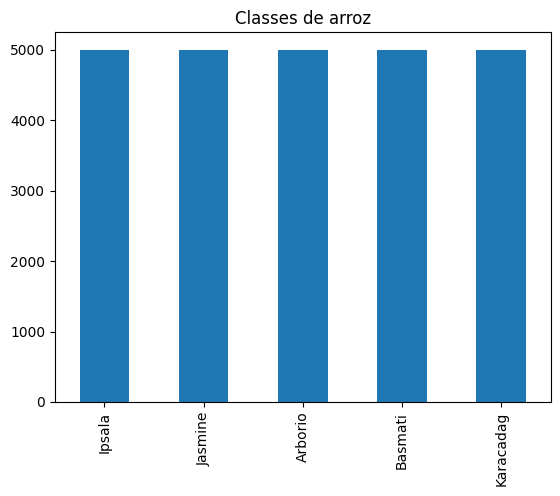

In [23]:
#Verificando que o dataset é de fato balanceado
df['class'].value_counts().plot.bar(title='Classes de arroz')

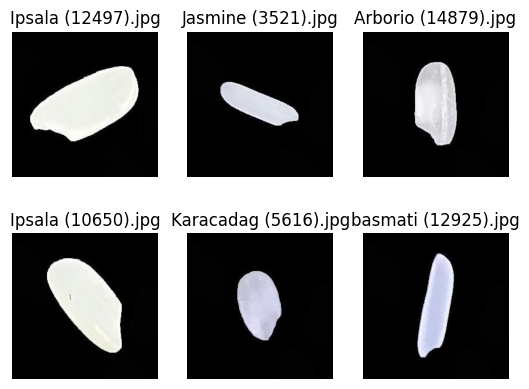

In [24]:
#Vendo algumas imagens do dataset
for n in range(6):
    sample = np.random.choice(images_path_list)
    sp = plt.subplot(2,3,n+1)
    sp.axis('Off')
    img = mpimg.imread(sample)
    plt.imshow(img)
    plt.title(sample.split(sep='/')[-1])

In [25]:
#Separação entre treino e teste
np.random.seed(10)

train,test = train_test_split(df[['images','class']],test_size=0.3, random_state=10,shuffle=True)

#Tratamento de imagens, data augmentation, com o ImageDataGenerator
train_datagen=ImageDataGenerator(validation_split=0.2,
                                 rescale=1.0/255,
                                 rotation_range=30,
                                 shear_range=0.15,
                                 zoom_range=0.25,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_aug = train_datagen.flow_from_dataframe(
            train, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class',
            subset='training')

test_aug = test_datagen.flow_from_dataframe(
            test, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class')

val_aug = train_datagen.flow_from_dataframe(
            train, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class',
            subset='validation')



Found 14000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.


**Criando o modelo**

Pra esse tipo de problema de classificação de imagem, é comum a utilização de uma rede neural convolucional (CNN). Sendo assim, tal modelo foi escolhido, treinado e usado a seguir

In [26]:
#Construindo a CNN

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),activation='relu',input_shape=(250,250,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_class, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001,decay=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

Criado o modelo e o dataset aumentado pra treinamento, partimos para o treinamento da rede, onde foi pré definido alguns parâmetros para ajudar a selecionar e salvar o melhor modelo.

A classe EarlyStopping monitorando o loss da validação foi usada pra otimizar as epochs do treinamento e monitorar o melhor modelo possível quando houver diminuição na progressão da diminuição da perda de validação.


In [27]:
#Geração de callbacks pra auxiliar o treinamento, considerando salvar o melhor modelo de acordo com a maior precisão da validação
model_path='best_model_colab.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          mode='auto')

In [ ]:
'''
Este bloco de código contém o treinamento do modelo.
O modelo já foi previamente treinado e carregado para o colab para poupar tempo
de processamento. É possível seguir executando os outros blocos caso queira pular
a execução desse

'''

#Treinando o modelo
history = model.fit(train_aug,
                      steps_per_epoch=50,
                      epochs=50,
                      validation_data=val_aug,
                      validation_steps=5,
                      callbacks=[checkpoint,earlystop]
                    )

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.5760
Epoch 1: val_loss improved from inf to 0.93432, saving model to best_model.hdf5
50/50 [==============================] - 455s 9s/step - loss: 1.0037 - accuracy: 0.5760 - val_loss: 0.9343 - val_accuracy: 0.6840
Epoch 2/50
16/50 [========>.....................] - ETA: 6:14 - loss: 0.8202 - accuracy: 0.6562

KeyboardInterrupt: ignored

Foi decidido fazer um checkpoint com a classe ModelCheckpoint usando o menor valor de perda (com monitor='val_loss' e mode = 'min') pois observou-se que o ganho de precisão (com monitor='val_accuracy' e mode = 'max') era menor frente a mitigação de perda com os parâmetros escolhidos.



Utilizando os mesmos callbacks e  dados pra treinamento, foi também treinado um modelo ResNet50 com e sem pesos sinápticos do pré trinamento do 'imagenet' pra comparação dos resutlados.

In [ ]:
'''
Este bloco de código contém o treinamento do modelo.
O modelo já foi previamente treinado e carregado para o colab para poupar tempo
de processamento. É possível seguir executando os outros blocos caso queira pular
a execução desse

'''

#Criando os modelos ResNet50 com os pesos sinápticos pre treinados com weights='imagenet'
model_path='ResNet50_model_colab.hdf5'
base_model2 = ResNet50(include_top=False,
                       weights='imagenet',
                  input_shape=(250,250,3)
                       )
x_ = base_model2.output
x_ = GlobalAveragePooling2D()(x_)
x_ = Dense(512,activation='relu')(x_)
pred = Dense(n_class, activation='softmax')(x_)
model2 = models.Model(inputs=base_model2.input, outputs=pred)

for layer in base_model2.layers:
    layer.trainable = False

model2.compile(optimizer=Adam(learning_rate=0.0001,decay=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

# Treinando o modelo ResNet50 coms os pesos carregados
history2 = model2.fit(train_aug,
                      steps_per_epoch=50,
                      epochs=50,
                      validation_data=val_aug,
                      validation_steps=5,
                      callbacks=[checkpoint,earlystop]
                    )


#Criando os modelos ResNet50 sem os pesos sinápticos pre treinados com weights='imagenet'
model_path='ResNet50_without_weights_model_colab.hdf5'
base_model3 = ResNet50(include_top=False,
                       weights=None,
                  input_shape=(250,250,3)
                       )
x_ = base_model3.output
x_ = GlobalAveragePooling2D()(x_)
x_ = Dense(512,activation='relu')(x_)
pred = Dense(n_class, activation='softmax')(x_)
model3 = models.Model(inputs=base_model3.input, outputs=pred)

for layer in base_model3.layers:
    layer.trainable = False

model3.compile(optimizer=Adam(learning_rate=0.0001,decay=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

# Treinando o modelo ResNet50 sem os pesos carregados
history3 = model3.fit(train_aug,
                      steps_per_epoch=50,
                      epochs=50,
                      validation_data=val_aug,
                      validation_steps=5,
                      callbacks=[checkpoint,earlystop]
                    )


A seguir vamos verificar a progressão das métricas de acurácia e loss dos modelos ao longo do treinamento

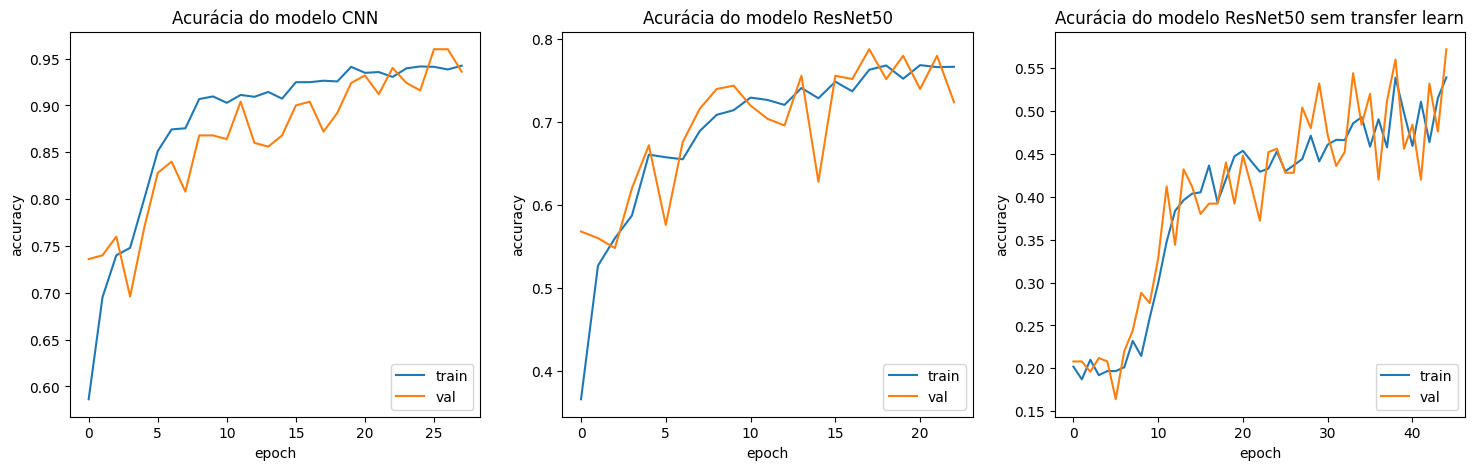

In [48]:
#Plotando os gráficos de accuracy e loss por epoch

#Para evitar que o modelo precise ser novamente treinado aqui no colab,
#os resultados do treinamento foram previamente salvos em um arquivo csv usando
#o bloco de código a seguir de maneira respectiva pra cada modelo testado (ajustando o parametro history, para os respectivos history2 e history3):
'''
#salvando csv dos resultados do treinamento pra cada epoch

epoch = [i for i in range(1,len(history.history['accuracy'])+1)]
t=pd.DataFrame({"accuracy":history.history['accuracy'],
                "val_accuracy":history.history['val_accuracy'],
                "epoch":epoch}).to_csv("train_accuracy.csv", index=False)

t=pd.DataFrame({"loss":history.history['loss'],
                "val_loss":history.history['val_loss'],
                "epoch":epoch}).to_csv("train_loss.csv", index=False)

'''
#Carregando os resultados da CNN do csv
train_test_acc = pd.read_csv(r'/content/train_accuracy.csv')
train_test_loss = pd.read_csv(r'/content/train_loss.csv')

#Carregando os resultados do csv para os modelos ResNet50
ResNet50_train_test_acc = pd.read_csv(r'/content/ResNet50_train_accuracy.csv')
ResNet50_train_test_loss = pd.read_csv(r'/content/ResNet50_train_loss.csv')
ResNet50_2_train_test_acc = pd.read_csv(r'/content/ResNet50_train_accuracy2.csv')
ResNet50_2_train_test_loss = pd.read_csv(r'/content/ResNet50_train_loss2.csv')

#Plot accuracy dos modelos

plt.figure(1, figsize=(18,5))
plt.subplot(131)
plt.plot(train_test_acc['accuracy'])
plt.plot(train_test_acc['val_accuracy'])
plt.title('Acurácia do modelo CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='lower right')
plt.savefig('train_test_acc.pdf', format='pdf')


plt.subplot(132)
plt.plot(ResNet50_train_test_acc['accuracy'])
plt.plot(ResNet50_train_test_acc['val_accuracy'])
plt.title('Acurácia do modelo ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='lower right')
plt.savefig('train_test_acc_resnet50.pdf', format='pdf')

plt.subplot(133)
plt.plot(ResNet50_2_train_test_acc['accuracy'])
plt.plot(ResNet50_2_train_test_acc['val_accuracy'])
plt.title('Acurácia do modelo ResNet50 sem transfer learn')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='lower right')
plt.savefig('train_test_acc_resnet50.pdf', format='pdf')
plt.show()


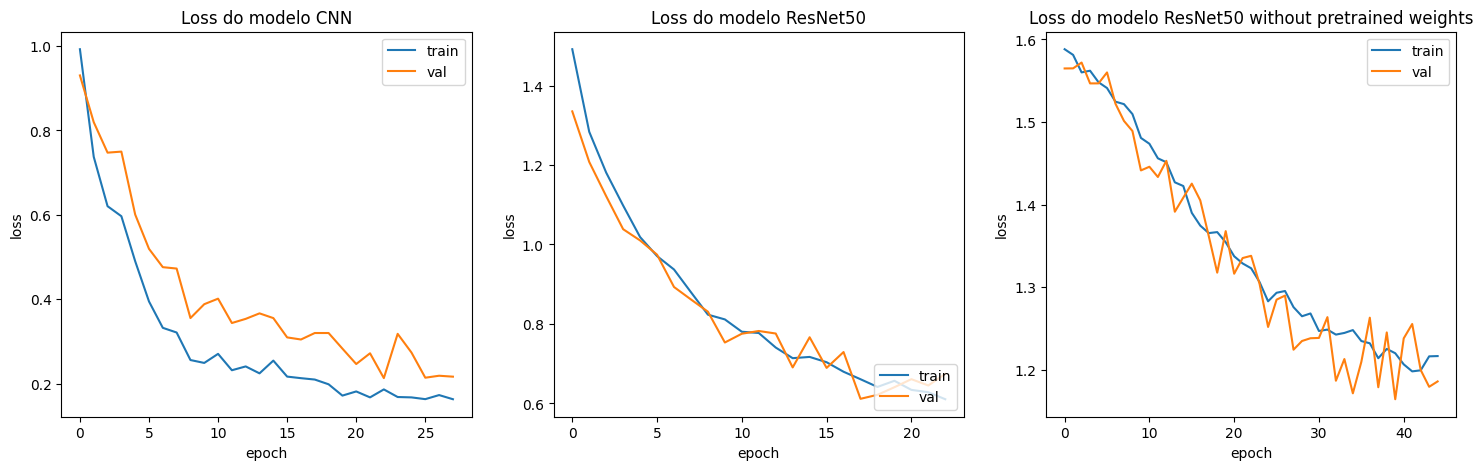

In [52]:
#Plot loss dos modelos

plt.figure(1, figsize=(18,5))

plt.subplot(131)
plt.plot(train_test_loss['loss'])
plt.plot(train_test_loss['val_loss'])
plt.title('Loss do modelo CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.savefig('train_test_loss.pdf', format='pdf')

plt.subplot(132)
plt.plot(ResNet50_train_test_loss['loss'])
plt.plot(ResNet50_train_test_loss['val_loss'])
plt.title('Loss do modelo ResNet50')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='lower right')
plt.savefig('train_test_acc_resnet50.pdf', format='pdf')

plt.subplot(133)
plt.plot(ResNet50_2_train_test_loss['loss'])
plt.plot(ResNet50_2_train_test_loss['val_loss'])
plt.title('Loss do modelo ResNet50 without pretrained weights')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.savefig('ResNet50_train_test_loss2.pdf', format='pdf')
plt.show()

In [57]:
#Descobrindo a epoch na qual o modelo foi salvo

print(f"CNN - {train_test_loss['epoch'].iloc[train_test_loss['val_loss'].idxmin()]}")
print(f"ResNet50 - {ResNet50_train_test_loss['epoch'].iloc[ResNet50_train_test_loss['val_loss'].idxmin()]}")
print(f"ResNet50_2 - {ResNet50_2_train_test_loss['epoch'].iloc[ResNet50_2_train_test_loss['val_loss'].idxmin()]}")

CNN - 23
ResNet50 - 18
ResNet50_2 - 40


In [58]:
#Confirmando o máximo de epochs
train_test_loss['epoch'].max()


print(f"CNN - {train_test_loss['epoch'].max()}")
print(f"ResNet50 - {ResNet50_train_test_loss['epoch'].max()}")
print(f"ResNet50_2 - {ResNet50_2_train_test_loss['epoch'].max()}")

CNN - 28
ResNet50 - 23
ResNet50_2 - 45


O modelo CNN parou antes de executar todas as 50 epochs, como pode ser observado acima, o melhor modelo foi salvo na epoch 23 e o treinamento foi executado até a epoch 28, devido ao parametro "patience=5" na classe EarlyStopping.

É possível notar que os modelos ResNet50 pre treinado com e sem os pesos sinápticos com os mesmos parâmetros treinaram em 23 e 45 epochs, e os melhores modelos salvos com 18 e 40 respectivamente.



Com o callback ModelCheckpoint, o melhor modelo foi salvo com o nome "best_model.hdf5". Vou prosseguir com esse modelo salvo carregando ele pra checar as métricas do mesmo.

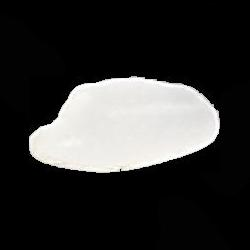

1/1 [==============================] - 1s 508ms/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 99.60%




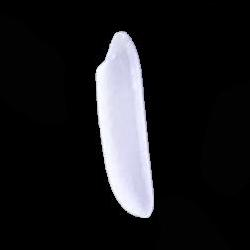

1/1 [==============================] - 0s 57ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 92.71%




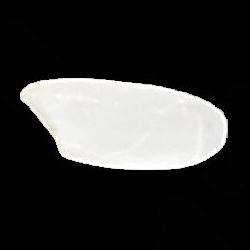

1/1 [==============================] - 0s 56ms/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 99.91%




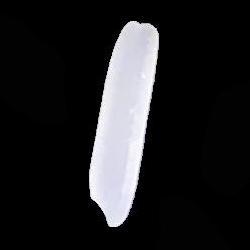

1/1 [==============================] - 0s 53ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 92.20%




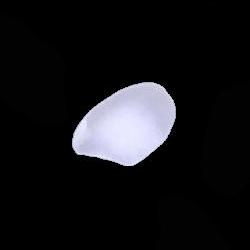

1/1 [==============================] - 0s 64ms/step
Label: Karacadag
Previsão: Karacadag
Probabilidade: 99.78%




In [59]:
#Verificando a probabilidade da classe predita pra cada modelo


#carregar o modelo
model_input_path = r"/content"
model_name =r"best_model.hdf5"
loaded_model = keras.models.load_model(os.path.join(model_input_path,model_name))

#Utilizando o modelo para fazer as predições
y_true = []
y_pred = []

cont = 0
for i in test['images']:
  cont+=1
  if cont > 5:
    break
  else:
    label = i.split(sep=" ")[0].capitalize()
    y_true.append(label)

    img_path = os.path.join(all_images,i)
    display(Image(filename=img_path,width=250))
    img = load_img(img_path,target_size=(250,250))
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = x.astype('float32')/255.0

    #Previsão
    prediction = loaded_model.predict(x)

    #printando as saídas do modelo
    predicted_class = np.argmax(prediction[0])
    probability = prediction[0][predicted_class]
    y_pred.append(classes[predicted_class])
    print(f"Label: {label}")
    print(f"Previsão: {classes[predicted_class]}")
    print(f"Probabilidade: {probability:.2%}")
    print('\n')








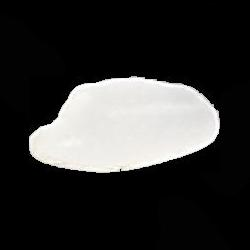

1/1 [==============================] - 1s 1s/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 96.98%




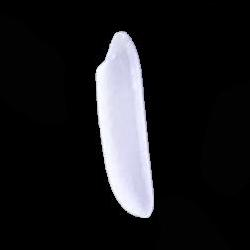

1/1 [==============================] - 0s 250ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 48.10%




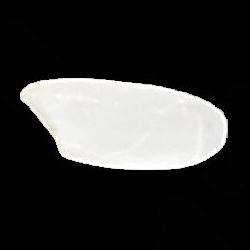

1/1 [==============================] - 0s 240ms/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 99.20%




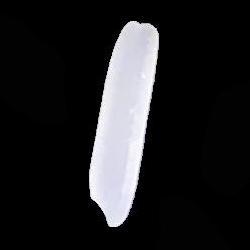

1/1 [==============================] - 0s 229ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 70.23%




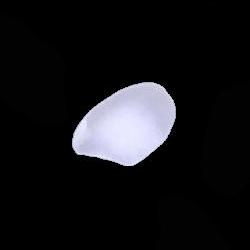

1/1 [==============================] - 0s 168ms/step
Label: Karacadag
Previsão: Karacadag
Probabilidade: 67.54%




In [62]:
#Analogamente, carregamos os modelos ResNet50 e repetimos o processo pra eles
model_input_path = r"/content"
model_name =r"ResNet50_model.hdf5"

loaded_model = keras.models.load_model(os.path.join(model_input_path,model_name))
#Utilizando o modelo para fazer as predições
y_true = []
y_pred = []

cont = 0
for i in test['images']:
  cont+=1
  if cont > 5:
    break
  else:
    label = i.split(sep=" ")[0].capitalize()
    y_true.append(label)

    img_path = os.path.join(all_images,i)
    display(Image(filename=img_path,width=250))
    img = load_img(img_path,target_size=(250,250))
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = x.astype('float32')/255.0

    #Previsão
    prediction = loaded_model.predict(x)

    #printando as saídas do modelo
    predicted_class = np.argmax(prediction[0])
    probability = prediction[0][predicted_class]
    y_pred.append(classes[predicted_class])
    print(f"Label: {label}")
    print(f"Previsão: {classes[predicted_class]}")
    print(f"Probabilidade: {probability:.2%}")
    print('\n')






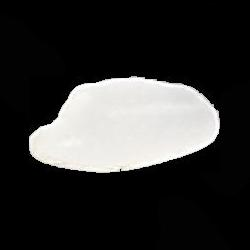

1/1 [==============================] - 1s 956ms/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 73.83%




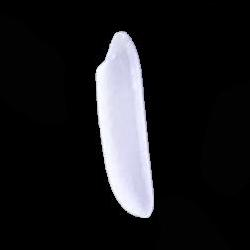

1/1 [==============================] - 0s 174ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 27.84%




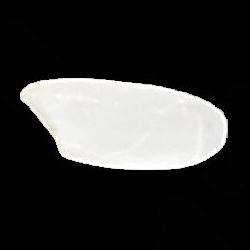

1/1 [==============================] - 0s 162ms/step
Label: Ipsala
Previsão: Ipsala
Probabilidade: 84.14%




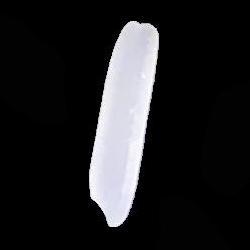

1/1 [==============================] - 0s 166ms/step
Label: Basmati
Previsão: Basmati
Probabilidade: 29.66%




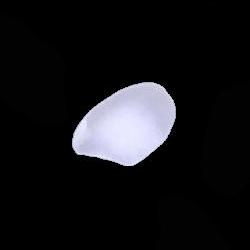

1/1 [==============================] - 0s 167ms/step
Label: Karacadag
Previsão: Jasmine
Probabilidade: 28.26%




In [63]:
model_input_path = r"/content"
model_name =r"ResNet50_without_weights_model.hdf5"

loaded_model = keras.models.load_model(os.path.join(model_input_path,model_name))

#Utilizando o modelo para fazer as predições
y_true = []
y_pred = []

cont = 0
for i in test['images']:
  cont+=1
  if cont > 5:
    break
  else:
    label = i.split(sep=" ")[0].capitalize()
    y_true.append(label)

    img_path = os.path.join(all_images,i)
    display(Image(filename=img_path,width=250))
    img = load_img(img_path,target_size=(250,250))
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = x.astype('float32')/255.0

    #Previsão
    prediction = loaded_model.predict(x)

    #printando as saídas do modelo
    predicted_class = np.argmax(prediction[0])
    probability = prediction[0][predicted_class]
    y_pred.append(classes[predicted_class])
    print(f"Label: {label}")
    print(f"Previsão: {classes[predicted_class]}")
    print(f"Probabilidade: {probability:.2%}")
    print('\n')

In [81]:
#para agilizar a predição do modelo para todas as imagens teste, a célula acima
#foi rodada sem o contador e os resultados gerados foram salvos localmente em um
#csv gerado pelo código a seguir:
'''
df_real_pred = pd.DataFrame({'real':y_true,'predito':y_pred}).to_csv('real_pred.csv', index=False)
'''
#Tal comando foi rodado de modo respectivo após a predição de cada modelo em cima do mesmo dataset de teste


#Lendo o csv com os resultados da predição

master_real_pred = {}

real_pred=pd.read_csv('/content/real_pred.csv')

y_true = real_pred['real']
y_pred = real_pred['predito']

In [82]:
#avaliando métricas gerais do modelo
accuracy = skm.accuracy_score(y_true,y_pred)
precision = skm.precision_score(y_true,y_pred,average='weighted')
recall = skm.recall_score(y_true,y_pred,average='weighted')
f1score = skm.f1_score(y_true,y_pred,average='weighted')
master_real_pred['CNN']={'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':f1score}

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1score:.2%}")

Accuracy: 97.72%
Precision: 97.73%
Recall: 97.72%
F1 score: 97.71%


In [83]:
#Utilizando o método classification_report pra verificar as métricas pra cada categoria
classification_report(y_true,y_pred,labels=classes,output_dict=True)

{'Arborio': {'precision': 0.9863387978142076,
  'recall': 0.9575596816976127,
  'f1-score': 0.971736204576043,
  'support': 1508},
 'Basmati': {'precision': 0.9700520833333334,
  'recall': 0.9776902887139107,
  'f1-score': 0.9738562091503268,
  'support': 1524},
 'Ipsala': {'precision': 0.9881266490765171,
  'recall': 1.0,
  'f1-score': 0.9940278699402787,
  'support': 1498},
 'Jasmine': {'precision': 0.9721627408993576,
  'recall': 0.959830866807611,
  'f1-score': 0.9659574468085107,
  'support': 1419},
 'Karacadag': {'precision': 0.9696778269109286,
  'recall': 0.9896840747904577,
  'f1-score': 0.9795788130185067,
  'support': 1551},
 'accuracy': 0.9772,
 'macro avg': {'precision': 0.9772716196068689,
  'recall': 0.9769529824019184,
  'f1-score': 0.9770313086987331,
  'support': 7500},
 'weighted avg': {'precision': 0.9772588321727315,
  'recall': 0.9772,
  'f1-score': 0.9771478885905718,
  'support': 7500}}

Matriz de confusão sem noramlização


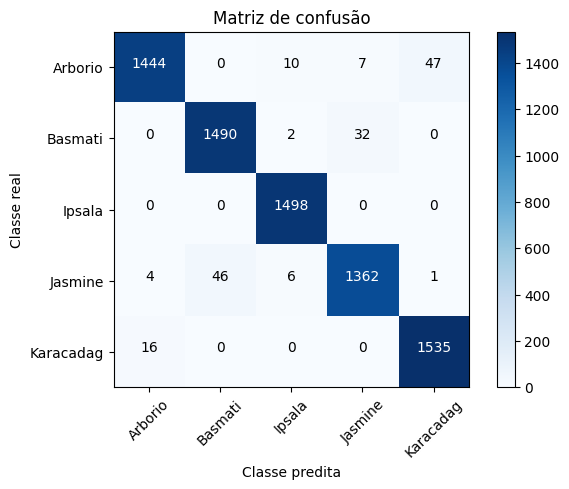

<Figure size 640x480 with 0 Axes>

In [84]:
cnf_matrix = confusion_matrix(y_true,y_pred,labels=classes)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      normalize=False,
                      title="Matriz de confusão")
plt.show()
plt.savefig('confusion_matrix.pdf', format='pdf')

In [85]:
#Resultados do ResNet50
real_pred=pd.read_csv('/content/ResNet50_real_pred.csv')

y_true = real_pred['real']
y_pred = real_pred['predito']

#avaliando métricas gerais do modelo
accuracy = skm.accuracy_score(y_true,y_pred)
precision = skm.precision_score(y_true,y_pred,average='weighted')
recall = skm.recall_score(y_true,y_pred,average='weighted')
f1score = skm.f1_score(y_true,y_pred,average='weighted')
master_real_pred['ResNet50']={'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':f1score}

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1score:.2%}")

Accuracy: 82.99%
Precision: 82.72%
Recall: 82.99%
F1 score: 82.21%


In [86]:
#Utilizando o método classification_report pra verificar as métricas pra cada categoria
classification_report(y_true,y_pred,labels=classes,output_dict=True)

{'Arborio': {'precision': 0.8137171888230313,
  'recall': 0.6372679045092838,
  'f1-score': 0.7147638527333582,
  'support': 1508},
 'Basmati': {'precision': 0.8667917448405253,
  'recall': 0.9094488188976378,
  'f1-score': 0.8876080691642652,
  'support': 1524},
 'Ipsala': {'precision': 0.8645833333333334,
  'recall': 0.9973297730307076,
  'f1-score': 0.926224426534408,
  'support': 1498},
 'Jasmine': {'precision': 0.7862190812720848,
  'recall': 0.6272022551092319,
  'f1-score': 0.6977655821246571,
  'support': 1419},
 'Karacadag': {'precision': 0.8026881720430108,
  'recall': 0.9626047711154094,
  'f1-score': 0.8754031075930812,
  'support': 1551},
 'accuracy': 0.8298666666666666,
 'macro avg': {'precision': 0.8267999040623971,
  'recall': 0.8267707045324542,
  'f1-score': 0.820353007629954,
  'support': 7500},
 'weighted avg': {'precision': 0.8271781605838965,
  'recall': 0.8298666666666666,
  'f1-score': 0.8221256478918059,
  'support': 7500}}

Matriz de confusão sem noramlização


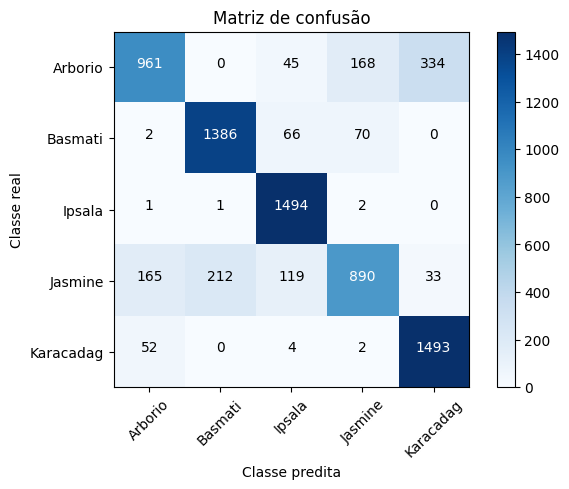

<Figure size 640x480 with 0 Axes>

In [75]:
cnf_matrix = confusion_matrix(y_true,y_pred,labels=classes)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      normalize=False,
                      title="Matriz de confusão")
plt.show()
plt.savefig('confusion_matrix.pdf', format='pdf')

In [87]:
#Resultados do ResNet50 sem o pré treinamento
real_pred=pd.read_csv('/content/ResNet50_real_pred2.csv')

y_true = real_pred['real']
y_pred = real_pred['predito']

#avaliando métricas gerais do modelo
accuracy = skm.accuracy_score(y_true,y_pred)
precision = skm.precision_score(y_true,y_pred,average='weighted')
recall = skm.recall_score(y_true,y_pred,average='weighted')
f1score = skm.f1_score(y_true,y_pred,average='weighted')
master_real_pred['ResNet50_2']={'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_score':f1score}

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1score:.2%}")

Accuracy: 50.60%
Precision: 55.94%
Recall: 50.60%
F1 score: 40.90%


In [88]:
#Utilizando o método classification_report pra verificar as métricas pra cada categoria
classification_report(y_true,y_pred,labels=classes,output_dict=True)

{'Arborio': {'precision': 1.0,
  'recall': 0.007294429708222812,
  'f1-score': 0.014483212639894666,
  'support': 1508},
 'Basmati': {'precision': 0.5276916260522818,
  'recall': 0.781496062992126,
  'f1-score': 0.6299920655911134,
  'support': 1524},
 'Ipsala': {'precision': 0.9744597249508841,
  'recall': 0.9933244325767691,
  'f1-score': 0.983801652892562,
  'support': 1498},
 'Jasmine': {'precision': 0.2982456140350877,
  'recall': 0.7787174066243834,
  'f1-score': 0.431303669008587,
  'support': 1419},
 'Karacadag': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1551},
 'accuracy': 0.506,
 'macro avg': {'precision': 0.5600793930076507,
  'recall': 0.5121664663803003,
  'f1-score': 0.41191612002643146,
  'support': 7500},
 'weighted avg': {'precision': 0.5593537643194522,
  'recall': 0.506,
  'f1-score': 0.4090271166637414,
  'support': 7500}}

Matriz de confusão sem noramlização


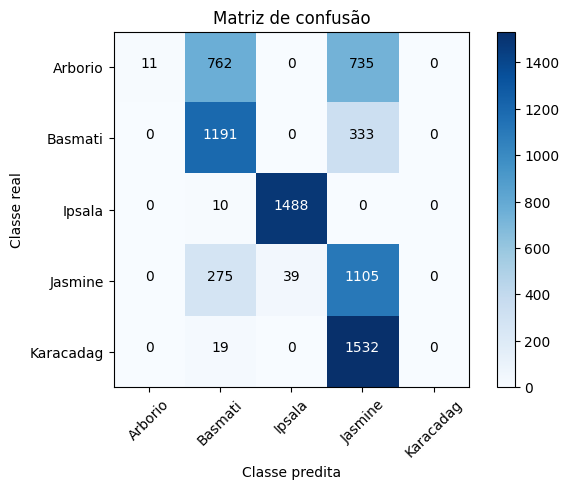

<Figure size 640x480 with 0 Axes>

In [89]:
cnf_matrix = confusion_matrix(y_true,y_pred,labels=classes)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      normalize=False,
                      title="Matriz de confusão")
plt.show()
plt.savefig('confusion_matrix.pdf', format='pdf')

In [78]:
data_metrics = [i for i in master_real_pred.items()]
metrics_index2 = [i[0] for i in data_metrics]
metrics_data2 =  [i[1] for i in data_metrics]
df_metrics2 = pd.DataFrame(metrics_data2, index=metrics_index2)
df_metrics2 = np.around(df_metrics2*100,2)
df_metrics2.sort_index()

,Accuracy,Precision,Recall,F1_score
CNN,97.72,97.73,97.72,97.71
ResNet50,82.99,82.72,82.99,82.21
ResNet50_2,50.60,55.94,50.60,40.90


**Discussão dos resultados**

Durante o treinamento, foi percebido de maneira geral que ganho de precisão era menor frente a mitigação de perda com os parâmetros escolhidos a medida que as epochs progrediam. Dessa forma, como o loss não ia diminuindo além de um mínimo previamente alcançado, o treinamento do modelo foi interrompido antes de todas as epochs de modo antecipado, evitando possíveis problemas como overfitting ou perda do melhor modelo ao fim do treinamento.




Para facilitar a comparação das métricas dos segue uma tabela abaixo comparando a precisão, recall, acurácia e o F1 score dos modelos:

|index|Accuracy|Precision|Recall|F1\_score|
|---|---|---|---|---|
|CNN|97\.72|97\.73|97\.72|97\.71|
|ResNet50|82\.99|82\.72|82\.99|82\.21|
|ResNet50\_2|50\.6|55\.94|50\.6|40\.9|


Um fato que vale ser apontado relacionado as métricas individuais de cada categoria é que nem sempre um valor alto significa que o modelo é bom. Por exemplo, no modelo identificado como ResNet50_2, a precisão da categoria "Arborio" é 100% porém o modelo só acertou 11 das 7500 imagens, o que conferiu a ele um recall e F1 score baixíssimos pra essa categoria. Portanto é importante avaliar as métricas em conjunto e não isoladamente.

O modelo de CNN proposto é bem adequado para o problema em questão, não havendo indícios de overfitting, possuindo boa precisão, revocação e outras métricas superiores à uma média de 97.7%. Para os mesmos parâmetros de treinamento, ele foi superior ao ResNet50 e aos ResNet50 sem os pesos do pré treinamento, onde tais modelos apresentaram acurácias de 82.99% e 50.6% respectivamente.

Como era esperado, usar um modelo pre treinado sem usar os pesos sinápticos do pré treinamento diminuiu muito a precisão do modelo. Isso mostra a importância dos parâmetros utilizados na hora de montar o modelo. Nesse caso foi variado um parâmetro grosseiro pra exemplificar como o ajuste dos hiperparâmetros pode afetar drasticamente a performace do modelo.

Para tentar melhorar a precisão dos modelos, poderia tentar aumentar o dataset de treinamento, ao invés de utilizar apenas 1/3, usar todo ele. Também poderia aumentar a quantidade de neurônios da camada prévia ao output ou ainda aumentar a quantidade de epochs do treinamento.

Ainda, para o caso da ResNet50, possibilitar retreinar o modelo com novos pesos seria uma abordagem pra melhorar a precisão do modelo, ainda mantendo os mesmos parâmetros de treinamento que os da CNN.

Esses bons resultados advém não só da rede neural, mas também da boa qualidade e equilíbrio entre os dados de entrada. Lembrando que neste caso os inputs estavam bem balanceados e abundantes.